<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 3
Авторы материала: Юрий Кашницкий (@yorko) и Максим Уваров (@maxis42). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 3 
## <center> Деревья решений для классификации и регрессии

**В этом задании мы разберемся с тем, как работает дерево решений в задаче регрессии, а также построим (и настроим) классифицирующие деревья решений в задаче прогнозирования сердечно-сосудистых заболеваний. 
Заполните код в клетках (где написано "Ваш код здесь") и ответьте на вопросы в [веб-форме](https://docs.google.com/forms/d/1bXgaJRh4naJOGzE_Li2k50TN0kOPJdNhMtHl6H4t3Lk/edit).**

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz

## 1. Простой пример восстановления регрессии с помощью дерева решений

Рассмотрим следующую одномерную задачу восстановления регрессии. Неформально, надо построить функцию $a(x)$, приближающую искомую зависимость $y = f(x)$ в терминах среднеквадратичной ошибки: $min \sum_i {(a(x_i) - f(x_i))}^2$. Подробно мы рассмотрим эту задачу в следующий раз ([4-я статья курса](https://habrahabr.ru/company/ods/blog/323890/)), а пока поговорим о том, как решать эту задачу с помощью дерева решений. Предварительно прочитайте небольшой раздел ["Дерево решений в задаче регрессии"](https://habrahabr.ru/company/ods/blog/322534/#derevo-resheniy-v-zadache-regressii) 3-ей статьи курса. 

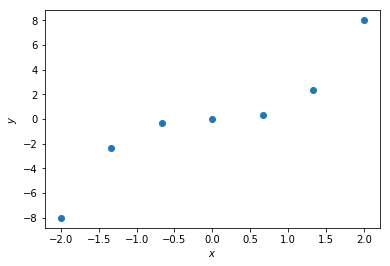

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

Проделаем несколько шагов в построении дерева решений. Исходя из соображений симметрии, выберем пороги для разбиения равными соответственно 0, 1.5 и -1.5. Напомним, что в случае задачи восстановления регрессии листовая вершина выдает среднее значение ответа по всем объектам обучающей выборки, попавшим в эту вершину.

Итак, начнём. Дерево глубины 0 состоит из одного корня, который содержит всю обучающую выборку. Как будут выглядеть предсказания данного дерева для $x \in [-2, 2]$? Постройте соответствующий график. Тут без `sklearn` – разбираемся просто с ручкой, бумажкой и Python, если надо.

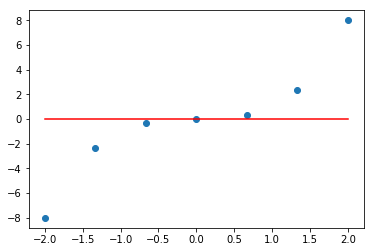

In [3]:
x = np.linspace(-2, 2, 50)
y_pred = [np.mean(X) ** 3 for i in x]
plt.scatter(X, y)
plt.plot(x, y_pred, color='r')

Произведем первое разбиение выборки по предикату $[x < 0]$. Получим дерево глубины 1 с двумя листьями. Постройте аналогичный график предсказаний для этого дерева.

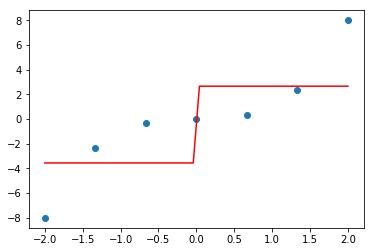

In [4]:
def predict(x):
    if x < 0:
        return np.mean(X[X < 0] ** 3)
    else:
        return np.mean(X[X >= 0] ** 3)

x = np.linspace(-2, 2, 50)
y_pred = [predict(i) for i in x]
plt.scatter(X, y)
plt.plot(x, y_pred, color='r')

В алгоритме построения дерева решений признак и значение порога, по которым происходит разбиение выборки, выбираются исходя из некоторого критерия. Для регрессии обычно используется дисперсионный критерий:
$$Q(X, j, t) = D(X) - \dfrac{|X_l|}{|X|} D(X_l) - \dfrac{|X_r|}{|X|} D(X_r),$$
где $X$ – выборка, находящаяся в текущей вершине, $X_l$ и $X_r$ – разбиение выборки $X$ на две части по предикату $[x_j < t]$ (то есть по $j$-ому признаку и порогу $t$), $|X|$, $|X_l|$, $|X_r|$ - размеры соответствующих выборок, а $D(X)$ – дисперсия ответов на выборке $X$:
$$D(X) = \dfrac{1}{|X|} \sum_{x_j \in X}(y_j – \dfrac{1}{|X|}\sum_{x_i \in X}y_i)^2,$$
где $y_i = y(x_i)$ – ответ на объекте $x_i$. При каждом разбиении вершины выбираются признак $j$ и значение порога $t$, максимизирующие значение функционала $Q(X, j, t)$.

В нашем случае признак всего один, поэтому $Q$ зависит только от значения порога $t$ (и ответов выборки в данной вершине). 

Постройте график функции $Q(X, t)$ в корне в зависимости от значения порога $t$ на отрезке $[-1.9, 1.9]$.

In [5]:
def D(X, y):
   mean = np.sum(y) / len(X)
   return np.sum([(yy - mean) ** 2 for yy in y]) / len(X)
    
def regression_var_criterion(X, y, t):
   Xl = [x for x in X if x < t]
   yl = [y[i] for i in range(len(y)) if X[i] < t]
   Xr = [x for x in X if x >= t]
   yr = [y[i] for i in range(len(y)) if X[i] >= t]
   return D(X, y) - len(Xl) / len(X) * D(Xl, yl) - len(Xr) / len(X) * D(Xr, yr)

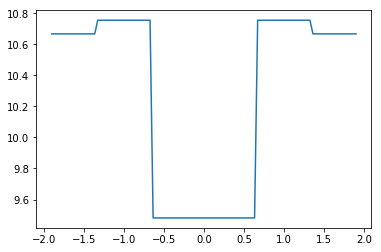

In [6]:
t = np.linspace(-1.9, 1.9, 100)
q = [regression_var_criterion(X, y, tt) for tt in t]
plt.plot(t, q)

**<font color='red'>Вопрос 1.</font> Оптимально ли с точки зрения дисперсионного критерия выбранное нами значение порога $t = 0$?**
- Да
- Нет

<b>Ответ: </b>???

Теперь произведем разбиение в каждой из листовых вершин. В левой (соответствующей ветви $x < 0$) – по предикату $[x < -1.5]$, а в правой (соответствующей ветви $x \geqslant 0$) – по предикату $[x < 1.5]$. Получится дерево глубины 2 с 7 вершинами и 4 листьями. Постройте график предсказаний этого дерева для $x \in [-2, 2]$.

In [7]:
def predict(x):
    if x < 0:
        a = X[X < 0]
        if x < -1.5:
            return np.mean(a[a < -1.5] ** 3)
        else:
            return np.mean(a[a >= -1.5] ** 3)
    else:
        a = X[X >= 0]
    if x < 1.5:
        return np.mean(a[a < 1.5] ** 3)
    else:
        return np.mean(a[a >= 1.5] ** 3)

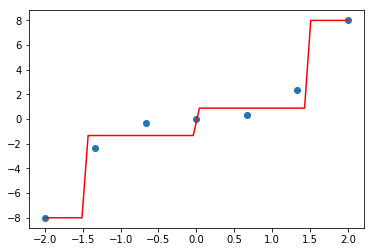

In [8]:
x = np.linspace(-2, 2, 50)
y_pred = [predict(i) for i in x]
plt.scatter(X, y)
plt.plot(x, y_pred, 'r')

**<font color='red'>Вопрос 2.</font> Из какого числа отрезков состоит график (необходимо считать как горизонтальные, так и вертикальные прямые), изображающий предсказания построенного дерева на отрезке [-2, 2]?**
- 5
- 6
- 7
- 8

<b>Ответ: </b> 7

## 2. Построение дерева решений для прогноза сердечно-сосудистых заболеваний
Считаем в `DataFrame` знакомый нам набор данных по сердечно-сосудистым заболеваниям. 

In [9]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [10]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Сделайте небольшие преобразования признаков: постройте признак "возраст в годах" (полных лет), а также постройте по 3 бинарных признака на основе `cholesterol` и `gluc`, где они, соответственно, равны 1, 2 или 3. Эта техника называется dummy-кодированием или One Hot Encoding (OHE), удобней всего в данном случае использовать `pandas.get_dummmies`. Исходные признаки `cholesterol` и `gluc` после кодирования использовать не нужно.

In [11]:
df['age_year'] = df['age'].apply(lambda a: int(a / 365.25))
df[['gluc_1', 'gluc_2', 'gluc_3']] = pd.get_dummies(df['gluc'])
df[['cholesterol_1', 'cholesterol_2', 'cholesterol_3']] = pd.get_dummies(df['cholesterol'])
df.drop(['cholesterol', 'gluc'], inplace=True, axis=1)
df.head()

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,age_year,gluc_1,gluc_2,gluc_3,cholesterol_1,cholesterol_2,cholesterol_3
id,,,,,,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,0,0,1,0,50,1,0,0,1,0,0
1,20228,1,156,85.0,140,90,0,0,1,1,55,1,0,0,0,0,1
2,18857,1,165,64.0,130,70,0,0,0,1,51,1,0,0,0,0,1
3,17623,2,169,82.0,150,100,0,0,1,1,48,1,0,0,1,0,0
4,17474,1,156,56.0,100,60,0,0,0,0,47,1,0,0,1,0,0


Разбейте выборку на обучающую и отложенную (holdout) части в пропорции 7/3. Для этого используйте метод `sklearn.model_selection.train_test_split`, зафиксируйте у него `random_state`=17.

In [12]:
X_train, X_valid, y_train, y_valid = train_test_split(df.drop('cardio', axis=1), df.cardio,test_size = 0.3, random_state=17)

Обучите на выборке `(X_train, y_train)` дерево решений с ограничением на максимальную глубину в 3. Зафиксируйте у дерева `random_state=17`. Визуализируйте дерево с помошью `sklearn.tree.export_graphviz`, `dot` и `pydot`. Пример дан в [статье](https://habrahabr.ru/company/ods/blog/322534/) под спойлером "Код для отрисовки дерева". Названия файлов писать без кавычек, для того чтобы работало в jupyter notebook. Обратите внимание, что команды в Jupyter notebook, начинающиеся с восклицательного знака – это терминальные команды (которые мы обычно запускаем в терминале/командной строке).

In [13]:
clf = DecisionTreeClassifier(random_state=17, max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [14]:
list(zip(X_train.columns, clf.feature_importances_))

[('age', 0.0979852655593451),
 ('gender', 0.0),
 ('height', 0.0),
 ('weight', 0.0),
 ('ap_hi', 0.82632433069188882),
 ('ap_lo', 0.0),
 ('smoke', 0.0),
 ('alco', 0.0),
 ('active', 0.0),
 ('age_year', 0.0),
 ('gluc_1', 0.0),
 ('gluc_2', 0.0),
 ('gluc_3', 0.0),
 ('cholesterol_1', 0.0),
 ('cholesterol_2', 0.0),
 ('cholesterol_3', 0.075690403748766094)]

In [15]:
export_graphviz(clf, feature_names=df.drop('cardio', axis=1).columns,out_file='./small_tree.dot', filled=True)

In [16]:
!dot -Tpng small_tree.dot -o small_tree.png

<img src="small_tree.png">

**<font color='red'>Вопрос 3.</font> Какие 3 признака задействуются при прогнозе в построенном дереве решений? (то есть эти три признака "можно найти в дереве")**
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- age, ap_hi, chol=3

<b>Ответ: </b>
- weight, height, gluc=3
- smoke, age, gluc=3
- age, weight, chol=3
- <b>age, ap_hi, chol=3</b>

Сделайте с помощью обученного дерева прогноз для отложенной выборки `(X_valid, y_valid)`. Посчитайте долю верных ответов (accuracy).

In [17]:
accuracy_score(y_valid, clf.predict(X_valid))

0.72128571428571431

Теперь на кросс-валидации по выборке  `(X_train, y_train)`  настройте глубину дерева, чтобы повысить качество модели. Используйте GridSearchCV, 5-кратную кросс-валидацию. Зафиксируйте у дерева `random_state`=17. Перебирайте параметр `max_depth` от 2 до 10. 

In [18]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, scoring='accuracy', n_jobs=-1, cv = 5, verbose=1)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   27.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [19]:
tree_grid.grid_scores_

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:747: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.71551, std: 0.00363, params: {'max_depth': 2},
 mean: 0.72771, std: 0.00485, params: {'max_depth': 3},
 mean: 0.73049, std: 0.00453, params: {'max_depth': 4},
 mean: 0.73096, std: 0.00523, params: {'max_depth': 5},
 mean: 0.73198, std: 0.00506, params: {'max_depth': 6},
 mean: 0.73037, std: 0.00360, params: {'max_depth': 7},
 mean: 0.72969, std: 0.00392, params: {'max_depth': 8},
 mean: 0.72822, std: 0.00475, params: {'max_depth': 9},
 mean: 0.72590, std: 0.00490, params: {'max_depth': 10}]

Нарисуйте график того, как меняется средняя доля верных ответов на кросс-валидации в зависимости от значения `max_depth`.

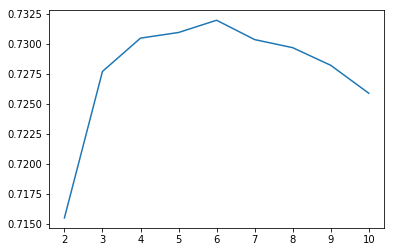

In [20]:
tree_grid_scores = tree_grid.cv_results_['mean_test_score']
plt.plot(list(range(2, 11)), tree_grid_scores)

Выведите лучшее значение `max_depth`, то есть такое, при котором среднее значение метрики качества на кросс-валидации максимально. Посчитайте также, какова теперь доля верных ответов на отложенной выборке. Все это можно сделать с помощью обученного экземпляра класса `GridSearchCV`.

In [21]:
tree_grid.best_params_

{'max_depth': 6}

In [22]:
accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid))

0.72580952380952379

In [23]:
clf = DecisionTreeClassifier(random_state=17, max_depth=3)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [27]:
acc1 = accuracy_score(y_valid, clf.predict(X_valid))
acc2 = accuracy_score(y_valid, tree_grid.best_estimator_.predict(X_valid))
(acc2 - acc1) / acc1 * 100

0.62718690169670022

**<font color='red'>Вопрос 4.</font> Имеется ли на кривой валидации по максимальной глубине дерева пик `accuracy`, если перебирать `max_depth` от 2 до 10? Повысила ли настройка глубины дерева качество классификации (accuracy) более чем на 1% на отложенной выборке (надо посмотреть на выражение (acc2 - acc1) / acc1 * 100%, где acc1 и acc2 – доли верных ответов на отложенной выборке до и после настройки max_depth соответственно)?**
- да, да
- да, нет
- нет, да
- нет, нет

<b>Ответ:</b> да, нет

Обратимся опять (как и в 1 домашке) к картинке, демонстрирующей шкалу SCORE для расчёта риска смерти от сердечно-сосудистого заболевания в ближайшие 10 лет.
<img src='../../img/SCORE2007.png' width=70%>

Создайте бинарные признаки, примерно соответствующие этой картинке:
- $age \in [45,50), \ldots age \in [60,65) $ (4 признака)
- верхнее артериальное давление: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 признака)

Если значение возраста или артериального давления не попадает ни в один из интервалов, то все бинарные признаки будут равны нулю. Далее будем строить дерево решений с этим признаками, а также с признаками ``smoke``, ``cholesterol``  и ``gender``. Из признака ``cholesterol`` надо сделать 3 бинарных, соотв-х уникальным значениям признака ( ``cholesterol``=1,  ``cholesterol``=2 и  ``cholesterol``=3), эта техника называется dummy-кодированием или One Hot Encoding (OHE). Признак ``gender`` надо перекодировать: значения 1 и 2 отобразить на 0 и 1. Признак лучше переименовать в ``male`` (0 – женщина, 1 – мужчина). В общем случае кодирование значений делает ``sklearn.preprocessing.LabelEncoder``, но в данном случае легко обойтись и без него.

Итак, дерево решений строится на 12 бинарных признаках (исходные признаки не берем).

Постройте дерево решений с ограничением на максимальную глубину = 3 и обучите его на всей исходной обучающей выборке. Используйте `DecisionTreeClassifier`, на всякий случай зафикисровав `random_state=17`, остальные аргументы (помимо `max_depth` и `random_state`) оставьте по умолчанию. 

**<font color='red'>Вопрос 5.</font> Какой бинарный признак из 12 перечисленных оказался самым важным для обнаружения ССЗ, то есть поместился в вершину построенного дерева решений?**
- Верхнее артериальное давление от 160 до 180 (мм рт.ст.)
- Пол мужской / женский
- Верхнее артериальное давление от 140 до 160 (мм рт.ст.)
- Возраст от 50 до 55 (лет)
- Курит / не курит
- Возраст от 60 до 65 (лет)

In [28]:
def age_group(age):
    if age < 45:
        return 0
    elif age < 50:
        return 1
    elif age < 55:
        return 2
    elif age < 60:
        return 3
    elif age < 65:
        return 4
    else:
        return 5

def ap_hi_group(ap_hi):
    if ap_hi < 120:
        return 0
    elif ap_hi < 140:
        return 1
    elif ap_hi < 160:
        return 2
    elif ap_hi < 180:
        return 3
    else:
        return 4

In [29]:
X_train_new = df.loc[:, ['age_year', 'ap_hi', 'smoke', 'cholesterol_1', 'cholesterol_2', 'cholesterol_3', 'gender']]
X_train_new['age_year'] = X_train_new['age_year'].apply(age_group)
X_train_new[['age_year_1', 'age_year_2', 'age_year_3', 'age_year_4']] = \
    pd.get_dummies(X_train_new['age_year']).loc[:, [i for i in range(1, 5)]]
X_train_new['ap_hi'] = X_train_new['ap_hi'].apply(ap_hi_group)
X_train_new[['ap_hi_1', 'ap_hi_2', 'ap_hi_3']] = pd.get_dummies(X_train_new['ap_hi']).loc[:, [i for i in range(1, 4)]]
X_train_new['male'] = X_train_new['gender'].apply(lambda x: x - 1)
X_train_new.drop(['age_year', 'ap_hi', 'gender'], inplace=True, axis=1)
X_train_new.head()

,smoke,cholesterol_1,cholesterol_2,cholesterol_3,age_year_1,age_year_2,age_year_3,age_year_4,ap_hi_1,ap_hi_2,ap_hi_3,male
id,,,,,,,,,,,,
0,0,1,0,0,0,1,0,0,0,0,0,1
1,0,0,0,1,0,0,1,0,0,1,0,0
2,0,0,0,1,0,1,0,0,1,0,0,0
3,0,1,0,0,1,0,0,0,0,1,0,1
4,0,1,0,0,1,0,0,0,0,0,0,0


In [30]:
y_train_new = df['cardio']

In [31]:
clf = DecisionTreeClassifier(random_state=17, max_depth=3)
clf.fit(X_train_new, y_train_new)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [32]:
list(sorted(zip(clf.feature_importances_, X_train_new.columns), reverse=True))

[(0.58038932828757983, 'ap_hi_2'),
 (0.24850190022977231, 'ap_hi_3'),
 (0.16983078072625682, 'cholesterol_3'),
 (0.00049705934758813221, 'age_year_3'),
 (0.00045763110415797701, 'cholesterol_1'),
 (0.00026970242638625966, 'age_year_2'),
 (5.3597878258682226e-05, 'smoke'),
 (0.0, 'male'),
 (0.0, 'cholesterol_2'),
 (0.0, 'ap_hi_1'),
 (0.0, 'age_year_4'),
 (0.0, 'age_year_1')]

In [33]:
export_graphviz(clf, feature_names=X_train_new.columns, 
                out_file='./small_tree_new.dot', filled=True)
!dot -Tpng small_tree_new.dot -o small_tree_new.png

<img src="small_tree_new.png">